In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Path to your CSV file and image directory
csv_path = 'Resources/sample_labels_cleaned.csv'
image_folder_path = 'Images'

# Step 1: Load the CSV file
data = pd.read_csv(csv_path)
print("CSV data loaded successfully!")

# Display the first few rows of the dataframe to verify
print(data.head())



CSV data loaded successfully!
        Image Index                                     Finding Labels  \
0  00000013_005.png  ['Emphysema', 'Infiltration', 'Pleural_Thicken...   
1  00000013_026.png                      ['Cardiomegaly', 'Emphysema']   
2  00000017_001.png                                     ['No Finding']   
3  00000030_001.png                                    ['Atelectasis']   
4  00000032_001.png              ['Cardiomegaly', 'Edema', 'Effusion']   

   Follow-up #  Patient ID  Patient Age  Patient Gender  View Position  \
0          5.0        13.0         60.0               1              0   
1         26.0        13.0         57.0               1              0   
2          1.0        17.0         77.0               1              0   
3          1.0        30.0         79.0               1              1   
4          1.0        32.0         55.0               0              0   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5604 non-null   object 
 1   Finding Labels               5604 non-null   object 
 2   Follow-up #                  5604 non-null   float64
 3   Patient ID                   5604 non-null   float64
 4   Patient Age                  5604 non-null   float64
 5   Patient Gender               5604 non-null   int64  
 6   View Position                5604 non-null   int64  
 7   OriginalImageWidth           5604 non-null   float64
 8   OriginalImageHeight          5604 non-null   float64
 9   OriginalImagePixelSpacing_x  5604 non-null   float64
 10  OriginalImagePixelSpacing_y  5604 non-null   float64
 11  Atelectasis                  5604 non-null   float64
 12  Cardiomegaly                 5604 non-null   float64
 13  Consolidation     

In [4]:

# Drop the 'Finding Labels' column
data = data.drop(columns=['Finding Labels'])

In [5]:
# Print columns
print(data.columns)

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'],
      dtype='object')


Razdelite podatke: Podelite svoje očišćene podatke na trening i test skup. Obično se koristi razmera od 80/20 ili 70/30, gde veći deo podataka ide za trening. Ovo omogućava modelu da uči na raznolikim primerima i da se validno evaluira na neviđenim podacima.

Transformacija podataka: Ako već niste, transformišite svoje slike tako da budu uniformne veličine koje CNN može efikasno obraditi. Takođe, normalizujte vrednosti piksela da budu u rasponu od 0 do 1 ili od -1 do 1, što pomaže u bržem i stabilnijem učenju.

Augmentacija podataka: Da bi se izbeglo preprilagođavanje i poboljšala generalizacija modela, razmislite o korišćenju tehnika augmentacije slika kao što su rotacije, translacija, izoštravanje, promena osvetljenja, itd.

Priprema generatora podataka: Koristite funkcije kao što su ImageDataGenerator iz Kerasa za automatsko učitavanje i transformaciju slika tokom treniranja. Ovo smanjuje potrošnju memorije i omogućava efikasnije učenje.

Definicija modela: Izgradite svoj CNN model. Počnite sa jednostavnijom arhitekturom i postepeno dodajte slojeve ili koristite prethodno obučene modele kao što su VGG, ResNet, ili neki drugi, ukoliko vam je cilj dublje učenje sa transferom znanja.

Kompilacija modela: Definišite funkciju gubitka i optimizator. Za klasifikaciju slika često se koristi kategorizovana unakrsna entropija, a optimizatori poput Adam ili SGD su standardni izbori.

Treniranje modela: Podesite broj epoha i veličinu serije (batch size) prema vašim resursima i potrebama. Pratite tačnost i gubitak na trening i validacionim skupovima tokom treniranja da biste pratili napredak i eventualno prilagođavali hiperparametre.

Evaluacija modela: Koristite test set da ocenite performanse modela. Fokusirajte se na metrike kao što su tačnost, preciznost, odziv i F1 skor, koje su ključne za medicinske primene.

Fine-tuning i optimizacija: Na osnovu početnih rezultata, možda ćete želeli da prilagodite arhitekturu modela ili hiperparametre. Iterativno poboljšanje modela je ključno.

In [6]:
# Split the data into training and testing sets
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

# Print the shapes of the training and testing sets
print(train_data.shape)

(4483, 25)


In [7]:
from tqdm.auto import tqdm  # Uvoz tqdm za vizuelni prikaz napretka

def load_and_preprocess_image(image_path):
    """Funkcija za učitavanje i preprocesiranje slike."""
    full_path = os.path.join(image_folder_path, image_path)
    image = load_img(full_path, target_size=(224, 224))  # Promena veličine slike na 224x224
    image = img_to_array(image)  # Pretvaranje slike u numpy niz
    image = image / 255.0  # Normalizacija vrednosti piksela od 0 do 1
    return image

# Primena funkcije na kolonu sa putanjama slika uz upotrebu tqdm za prikaz napretka
train_data['image_array'] = [load_and_preprocess_image(path) for path in tqdm(train_data['Image Index'], desc='Processing training images')]
test_data['image_array'] = [load_and_preprocess_image(path) for path in tqdm(test_data['Image Index'], desc='Processing testing images')]

# Provera prvih nekoliko redova da se vidi struktura podataka
print(train_data.head())

Processing training images:   0%|          | 0/4483 [00:00<?, ?it/s]

Processing testing images:   0%|          | 0/1121 [00:00<?, ?it/s]

           Image Index  Follow-up #  Patient ID  Patient Age  Patient Gender  \
731   00003838_000.png          0.0      3838.0         52.0               0   
1569  00008127_001.png          1.0      8127.0         32.0               0   
3684  00018091_016.png         16.0     18091.0         41.0               1   
3892  00019176_062.png         62.0     19176.0         66.0               0   
3042  00014958_014.png         14.0     14958.0         19.0               0   

      View Position  OriginalImageWidth  OriginalImageHeight  \
731               1              2048.0               2500.0   
1569              1              2048.0               2500.0   
3684              0              2500.0               2048.0   
3892              0              3056.0               2544.0   
3042              1              2820.0               2991.0   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  ...  Fibrosis  \
731                         0.168                    

In [8]:
# Pretvaranje oznaka iz DataFrame-a u numpy niz
labels = data.iloc[:, 10:-1]  # Pretpostavka da su oznake dijagnoza između 10-te kolone i predzadnje
y_train = train_data.iloc[:, 10:-1].values
y_test = test_data.iloc[:, 10:-1].values

# Provera
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Train labels shape: (4483, 15)
Test labels shape: (1121, 15)


In [9]:
# Pretvaranje lista slika u numpy nizove
X_train = np.stack(train_data['image_array'].values)
X_test = np.stack(test_data['image_array'].values)

# Provera
print("Train images shape:", X_train.shape)
print("Test images shape:", X_test.shape)


Train images shape: (4483, 224, 224, 3)
Test images shape: (1121, 224, 224, 3)


In [12]:
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras import regularizers

# Definisanje modela
model = models.Sequential([
    Input(shape=(224, 224, 3)),  # Dodavanje Input sloja
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularizacija
    Dropout(0.5),  # Dropout sloj
    layers.Dense(15, activation='sigmoid')  # Uskladite broj izlaznih jedinica sa brojem oznaka
])

# Kompilacija modela
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Koristi se binary_crossentropy jer je svaka oznaka binarna
              metrics=['accuracy'])

# Prikaz arhitekture modela
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,132,943 (42.47 MB)

 Trainable params: 11,132,943 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.3037 - loss: 0.7554 - val_accuracy: 0.5584 - val_loss: 0.2292
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.4634 - loss: 0.2670 - val_accuracy: 0.5584 - val_loss: 0.2183
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 360ms/step - accuracy: 0.5021 - loss: 0.2499 - val_accuracy: 0.5584 - val_loss: 0.2177
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5322 - loss: 0.2420 - val_accuracy: 0.5584 - val_loss: 0.2217
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - accuracy: 0.5349 - loss: 0.2445 - val_accuracy: 0.5584 - val_loss: 0.2134
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.5417 - loss: 0.2372 - val_accuracy: 0.5584 - val_loss: 0.2156
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - accuracy: 0.5224 - loss: 0.2384 - val_accuracy: 0.5584 - val_loss: 0.2143
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 360ms/step - accuracy: 0.5298 - loss: 0

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5898 - loss: 0.2037
Test loss: 0.21403832733631134
Test accuracy: 0.5584299564361572


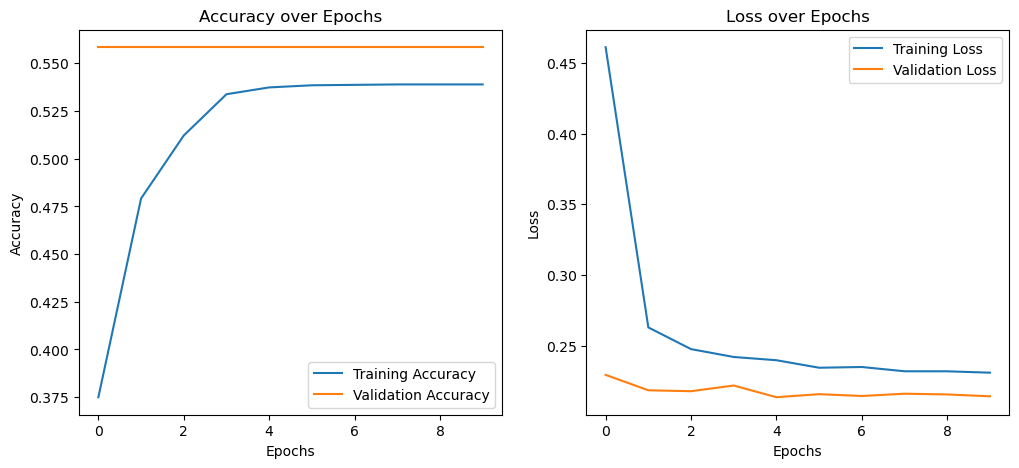

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Proverite distribuciju klasa
print(np.sum(y_train, axis=0))


[ 408.  123.  177.   92.  511.   97.   71.   10.  788.  238. 2416.  256.
  140.   48.  217.]


rezultati pokazuju znatnu varijabilnost u broju instanci po klasama, što ukazuje na potencijalni problem nebalansiranosti klasa u vašem datasetu. Klasa sa indeksom 10 (2416 instanci) znatno je zastupljenija u odnosu na ostale, što može uzrokovati pristrasnost modela prema toj kategoriji.

In [19]:
# Strategije za Rešavanje Neuravnoteženosti Klasa
# Ponderisanje Klasa: Prilagodite težine gubitka u procesu treniranja kako bi se manje zastupljenim klasama dala veća važnost.

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=np.ravel(y_train))
class_weights = dict(enumerate(class_weights))

# Treniranje modela sa ponderisanim klasama
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 57s 391ms/step - accuracy: 0.5384 - loss: 0.2704 - val_accuracy: 0.5584 - val_loss: 0.2264
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.5289 - loss: 0.2968 - val_accuracy: 0.5584 - val_loss: 0.2208
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5415 - loss: 0.2695 - val_accuracy: 0.5584 - val_loss: 0.2250
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - accuracy: 0.5431 - loss: 0.2674 - val_accuracy: 0.5584 - val_loss: 0.2251
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - accuracy: 0.5399 - loss: 0.2569 - val_accuracy: 0.5584 - val_loss: 0.2284
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 377ms/step - accuracy: 0.5408 - loss: 0.2653 - val_accuracy: 0.5584 - val_loss: 0.2216
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 379ms/step - accuracy: 0.5440 - loss: 0.2567 - val_accuracy: 0.5584 - val_loss: 0.2239
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 359ms/step - accuracy: 0.5319 - loss: 0

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5898 - loss: 0.2128
Test loss: 0.22250719368457794
Test accuracy: 0.5584299564361572


In [22]:
from sklearn.utils.class_weight import compute_sample_weight

# Računanje težina za svaki uzorak
sample_weights = compute_sample_weight('balanced', y_train)

# Treniranje modela sa ponderisanim uzorcima
history = model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 391ms/step - accuracy: 0.5321 - loss: 1.1500 - val_accuracy: 0.5584 - val_loss: 0.4877
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 379ms/step - accuracy: 0.4879 - loss: 1.2143 - val_accuracy: 0.5584 - val_loss: 0.4540
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 374ms/step - accuracy: 0.5405 - loss: 1.0012 - val_accuracy: 0.5584 - val_loss: 0.4861
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3387 - loss: 1.2519 - val_accuracy: 0.2864 - val_loss: 0.5441
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 372ms/step - accuracy: 0.1775 - loss: 1.9743 - val_accuracy: 0.1070 - val_loss: 0.5357
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 371ms/step - accuracy: 0.1308 - loss: 1.2486 - val_accuracy: 0.0714 - val_loss: 0.3962
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 377ms/step - accuracy: 0.0665 - loss: 2.1662 - val_accuracy: 0.0714 - val_loss: 0.4269
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 375ms/step - accuracy: 0.0705 - loss: 1

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0674 - loss: 0.4122
Test loss: 0.41518551111221313
Test accuracy: 0.07047279179096222


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augmentacija se primenjuje samo na trening podatke


In [25]:
from sklearn.metrics import hamming_loss, jaccard_score

# Predviđanja modela
predictions = model.predict(X_test)
# Pretvaranje predviđanja u binarni oblik
predictions = (predictions > 0.5).astype(int)

# Izračunavanje Hamming loss-a
hamming = hamming_loss(y_test, predictions)
print('Hamming Loss:', hamming)

# Izračunavanje Jaccard score-a
jaccard = jaccard_score(y_test, predictions, average='samples')
print('Jaccard Score:', jaccard)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
Hamming Loss: 0.0824264049955397
Jaccard Score: 0.0
